# Observational Data
## From Observational Data to Conditionally Randomized Experiments

Causal inference from observational data relies on the idea that, under the assumptions of the **Rubin Causal Model** (Rubin, 1978), an observational study can be regarded as a *conditionally randomized experiment*. 

Under the assumptions of ignorability (see below), the observed data represent the essential features of a randomized experiment, enabling the identification and consistent estimation of causal effects within the **potential outcomes framework**.


## Potential Outcomes Framework
- (Neyman, 1923; Rubin, 1974 and 1978): Rubin extended Neyman’s theory for randomized experiments to observational studies.
- Specifically, when treatment assignment is **strongly ignorable** given a set of observed covariates — that is, when the following two conditions hold:

$$
(Y(1), Y(0)) \perp T \mid X
$$

$$
0 < P(T = 1 \mid X) < 1,
$$

then conditioning on $X$ renders the treatment assignment mechanism analogous to that of a randomized controlled trial. More explanation in [assumptions guide](https://www.uniqcret.com/post/causal-inference-assumptions-guide.) and in [2020 Neal](https://www.bradyneal.com/Introduction_to_Causal_Inference-Aug27_2020-Neal.pdf)

### Assumptions
#### **(1) Consistency**: 

$$
Y(A) = Y(a) = Y \quad \text{when } A = a
$$

links the potential outcomes to the observed outcomes by requiring that the two are equal under the same treatment assignments. This ties the potential outcome $Y(a)$ to the factual outcome $Y$ when the treatment actually received is $A = a$. 

#### **(2) Stable Unit Treatment Value Assumption (SUTVA)**: 

SUTVA combines consistency and no interference. The **no interference** assumption states that:

$$
Y_i(a_i) \text{ depends only on } a_i \text{ (not on } a_j \text{ for } j \neq i)
$$

implies that there is no interference between treatment assignment and outcomes across patients. In the assumption of consistency, we are implicitly making the assumption of no interference; that is, whether one individual receives treatment (or not) has no effect on the potential outcomes of any other individual. This is encapsulated by the usual statistical ‘i.i.d.’ assumption, but it can easily be violated in a study of the effect of a vaccine or if a treatment is assigned at a group level.

#### **(3) Positivity**: 

$$
0 < P(T = 1 \mid X) < 1 \quad \text{with probability } 1
$$

or more strictly (strict positivity):

$$
\varepsilon < P(T = 1 \mid X) < 1 - \varepsilon \quad \text{with probability } 1, \text{ for some } \varepsilon > 0
$$

This states that, for any possible patient characteristic, treatment assignment is not deterministic. For all but a measure zero subset of the population, the probability of receiving treatment **and** of receiving control is non-zero.

#### **(4) Exchangeability (No unobserved confounding)**: 

$$
Y(a) \perp\!\!\!\perp A \mid X \quad \text{for all } a \in \mathcal{A}
$$

or equivalently:

$$
(Y(1), Y(0)) \perp\!\!\!\perp A \mid X
$$

This implies that conditioning on the patient characteristics (covariates $X$) is sufficient to remove confounding bias in estimated HTEs. This is also called *conditional exchangeability*, *conditional ignorability*, or *causal sufficiency*.

By exchangeability $(4)$ and consistency $(1)$, the estimation of the average (causal) treatment effect can be done based on observed data:

$$
\mathbb{E}[Y(a)|T=t] 
\overset{(4)}{=}\mathbb{E}[Y(a)|T=t, X=x]
\overset{(1)}{=}\mathbb{E}[Y|T=t, X=x]
$$

## Validation Checks

diagnostics (Peters 3.3, 6.4, 6.9; Shalizi (2019). Advanced Data Analysis from an Elementary Point of View.
Chapter 21.1.3-21.1.5): 
- consistency
- SUTVA
- positivity
- exchangeability


In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy.special import expit
from utils import *
import plotly

plotly.offline.init_notebook_mode(connected=True)

## Data Generation


In [2]:
# --- 1. Synthetic Data Generation ---
N = 1000  # Number of observations
ATE = 5.0 # Average Treatment Effect
np.random.seed(42)

# Coefficients for the causal model
beta_x1_t = 0.5
beta_x2_t = 1.0
beta_x1_y = 1.0
beta_x2_y = 2.0
intercept_t = -1.5
intercept_y = 10.0
beta_x1_t_v = 5.0  # High coefficient for violation
beta_x2_t_v = 3.0  # High coefficient for violation
intercept_t_v = 0.0

# Generate Covariates (X)
X1 = np.random.normal(loc=40, scale=10, size=N)
X2 = np.random.binomial(n=1, p=0.4, size=N)

# Generate 8 more covariates
X3 = np.random.uniform(low=0, high=100, size=N)
X4 = np.random.normal(loc=10, scale=2, size=N)
X5 = np.random.randint(low=0, high=5, size=N) # Categorical-like
X6 = np.random.gamma(shape=2, scale=2, size=N)
X7 = np.random.poisson(lam=3, size=N)
X8 = np.random.exponential(scale=1, size=N)
X9 = np.random.normal(loc=50, scale=5, size=N)
X10 = np.random.binomial(n=1, p=0.7, size=N)

# Calculate Propensity Scores

# 1. Good Positivity (Mild dependence on X)
# Add new covariates to the linear predictor for 'good' treatment assignment
linear_predictor_t = (
    intercept_t
    + (beta_x1_t * (X1 - X1.mean()) / X1.std())
    + (beta_x2_t * X2)
    + (0.1 * (X3 - X3.mean()) / X3.std()) # Small effect
    + (0.2 * (X4 - X4.mean()) / X4.std()) # Small effect
)
prob_t = expit(linear_predictor_t)
T = np.random.binomial(n=1, p=prob_t, size=N)

# 2. Bad Positivity (Extreme dependence on X)
# Add new covariates to the linear predictor for 'violate' treatment assignment (with higher coefficients)
linear_predictor_t_v = (
    intercept_t_v
    + (beta_x1_t_v * (X1 - X1.mean()) / X1.std())
    + (beta_x2_t_v * X2)
    + (1.5 * (X3 - X3.mean()) / X3.std()) # Larger effect
    + (1.0 * (X4 - X4.mean()) / X4.std()) # Larger effect
    + (0.8 * X5) # Larger effect for categorical
)
prob_t_violate = expit(linear_predictor_t_v)
T_Violate = np.random.binomial(n=1, p=prob_t_violate, size=N)

# Create DataFrame including all covariates
data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4,
    'X5': X5,
    'X6': X6,
    'X7': X7,
    'X8': X8,
    'X9': X9,
    'X10': X10,
    'T_Treatment': T,
    'T_Violate_Positivity': T_Violate,
    'P_Propensity_Score_Good': prob_t,
    'P_Propensity_Score_Violate': prob_t_violate
})

data.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,T_Treatment,T_Violate_Positivity,P_Propensity_Score_Good,P_Propensity_Score_Violate
0,44.967142,0,21.906881,8.786599,4,2.594468,2,0.123125,52.142193,0,0,0,0.186779,0.973667
1,38.617357,0,3.672136,10.422567,3,2.009630,4,0.864453,47.578047,1,0,0,0.154556,0.357944
2,46.476885,1,10.802575,12.400158,1,3.812620,0,0.453005,47.091020,0,0,1,0.479882,0.997901
3,55.230299,1,33.886065,9.016195,4,0.319852,4,0.083726,49.157490,1,0,1,0.529235,0.999997
4,37.658466,0,80.258568,6.246895,1,1.507062,1,2.180253,44.745755,1,0,0,0.131278,0.325387


In [3]:
# DAG Plot
causal_model = {
    'X1 -> T': beta_x1_t,
    'X2 -> T': beta_x2_t,
    'X1 -> Y': beta_x1_y,
    'X2 -> Y': beta_x2_y,
    'T -> Y': ATE
}

print("Causal Model (DAG Structure and Weights):")
for path, weight in causal_model.items():
    print(f"{path}: {weight}")

causal_model_violate_positivity = {
    'X1 -> T': beta_x1_t_v,
    'X2 -> T': beta_x2_t_v,
    'X1 -> Y': beta_x1_y,
    'X2 -> Y': beta_x2_y,
    'T -> Y': ATE
}

print("Causal Model with violated positivity(DAG Structure and Weights):")
for path, weight in causal_model_violate_positivity.items():
    print(f"{path}: {weight}")

Causal Model (DAG Structure and Weights):
X1 -> T: 0.5
X2 -> T: 1.0
X1 -> Y: 1.0
X2 -> Y: 2.0
T -> Y: 5.0
Causal Model with violated positivity(DAG Structure and Weights):
X1 -> T: 5.0
X2 -> T: 3.0
X1 -> Y: 1.0
X2 -> Y: 2.0
T -> Y: 5.0


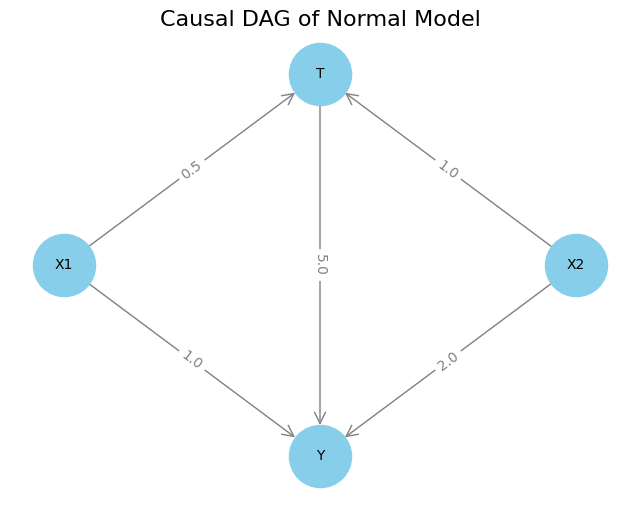

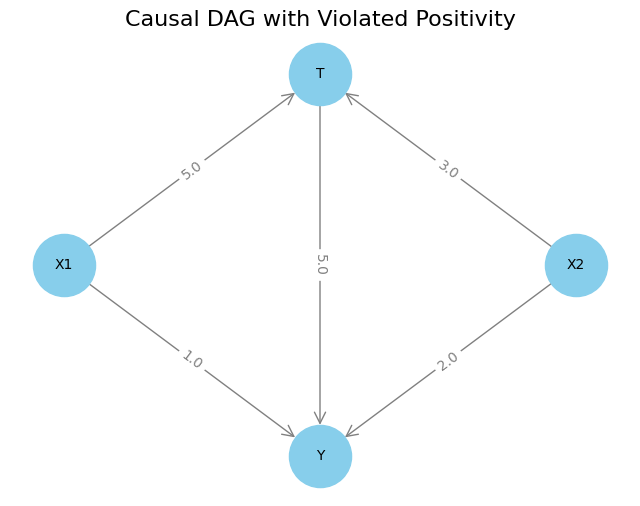

In [18]:
# Plot 1: Causal DAG of Normal Model
plot_causal_dag(causal_model, 'Causal DAG of Normal Model', node_color='skyblue')


# Plot 2: Causal DAG with Violated Positivity
plot_causal_dag(causal_model_violate_positivity, 'Causal DAG with Violated Positivity', node_color='skyblue')


## Validation of Positivity Assumption

In [19]:
# --- Plotly Boxplot Execution and Display ---
# Create boxplot for Good Overlap
fig_boxplot_good = plot_propensity_score_boxplots(
    data,
    'P_Propensity_Score_Good',
    'T_Treatment',
    'Boxplots of Propensity Scores: Good Positivity'
)
plotly.offline.iplot(fig_boxplot_good)

# Create boxplot for Severe Violation
fig_boxplot_violate = plot_propensity_score_boxplots(
    data,
    'P_Propensity_Score_Violate',
    'T_Violate_Positivity',
    'Boxplots of Propensity Scores: Violation of Positivity'
)
plotly.offline.iplot(fig_boxplot_violate)


## Validation of Exchangeability Assumption

[smd plot]https://cran.r-project.org/web/packages/tableone/vignettes/smd.html 
TODO: explanation and assessment

In [22]:
# Define covariates to check balance for
covariates_to_balance = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']

# Create a subplot figure for both plots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=(
    '1. Good Positivity',
    '2. Severe Violation of Positivity'
))

# Calculate SMD for Good Overlap case
smd_good = calculate_smd(data, covariates_to_balance, 'T_Treatment')

# Calculate SMD for Severe Violation case
smd_violate = calculate_smd(data, covariates_to_balance, 'T_Violate_Positivity')

# Determine a common x-axis limit for both plots
max_smd_abs = max(smd_good.abs().max(), smd_violate.abs().max())
common_x_limit = max_smd_abs + 0.1 # Add a small buffer

# Plot SMD for Good Overlap case (subplot 1)
plot_love_plot(smd_good, '1. Good Overlap', fig, row=1, col=1, x_limit=common_x_limit, dot_color='skyblue')

# Plot SMD for Severe Violation case (subplot 2)
plot_love_plot(smd_violate, '2. Severe Violation', fig, row=1, col=2, x_limit=common_x_limit, dot_color='skyblue')

# Update overall layout of the figure
fig.update_layout(height=500, width=1000, showlegend=False)
plotly.offline.iplot(fig)
